In [12]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.utils import to_categorical
from datetime import date
from sklearn import model_selection
from sklearn import preprocessing
from collections import deque
import random
from numpy import newaxis
import sys
from datetime import date
import plotly.express as px

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [36]:
with open('/content/gdrive/MyDrive/Colab Notebooks/data/GEFCom2014-E.csv', 'r') as z:
    df = pd.DataFrame(pd.read_csv(z))



In [37]:
df


Date  Hour    load      T
0      01-01-2004     1     NaN  37.33
1      01-01-2004     2     NaN  37.67
2      01-01-2004     3     NaN  37.00
3      01-01-2004     4     NaN  36.33
4      01-01-2004     5     NaN  36.00
...           ...   ...     ...    ...
96427  31-12-2014    20  4012.0  18.00
96428  31-12-2014    21  3856.0  16.67
96429  31-12-2014    22  3671.0  17.00
96430  31-12-2014    23  3499.0  15.33
96431  31-12-2014    24  3345.0  15.33

[96432 rows x 4 columns]

In [38]:
df=df.iloc[17546:]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa0d6aaba8>,
      dtype=object)

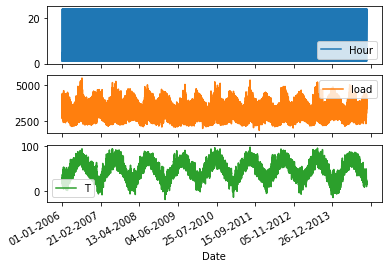

In [39]:
df.set_index('Date')[['Hour','load','T']].plot(subplots=True)


In [13]:
fig=px.line(df,x='Date',y='load')
fig.update_xaxes(
    rangeslider_visible=True

)
fig.show()

In [14]:
fig=px.line(df,x='Date',y='T')
fig.update_xaxes(
    rangeslider_visible=True
)


In [19]:
fig=px.line(df,x='T',y='load')
fig.update_xaxes(
    rangeslider_visible=True
)
fig.show()

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78886 entries, 17546 to 96431
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    78886 non-null  object 
 1   Hour    78886 non-null  int64  
 2   load    78886 non-null  float64
 3   T       78886 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.4+ MB


In [43]:
df_input=df.iloc[:,[2,3]]

In [44]:
df_input

load      T
17546  2758.0  21.33
17547  2705.0  19.00
17548  2709.0  19.33
17549  2753.0  18.67
17550  2849.0  18.00
...       ...    ...
96427  4012.0  18.00
96428  3856.0  16.67
96429  3671.0  17.00
96430  3499.0  15.33
96431  3345.0  15.33

[78886 rows x 2 columns]

In [129]:
scaler=preprocessing.MinMaxScaler()
scaled_data=scaler.fit_transform(df_input)

In [131]:
target=scaled_data[:,0]
features=scaled_data


In [132]:
tf.keras.preprocessing.sequence.TimeseriesGenerator(features,target,length=2,batch_size=1,sampling_rate=1)[0]

(array([[[0.25629229, 0.342     ],
         [0.24194858, 0.32173913]]]), array([0.24303112]))

In [133]:
x_train,x_test,y_train,y_test=model_selection.train_test_split(features,target,test_size=0.20,random_state=123,shuffle=False)

In [134]:
x_train.shape

(63108, 2)

In [111]:
x_test.shape

(15778, 2)

In [148]:
num_features=2
batchs=30
windowl=120
train_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train,y_train,batch_size=batchs,length=windowl,sampling_rate=1)
test_gen=tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test,y_test,batch_size=batchs,length=windowl,sampling_rate=1)

In [149]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=128,input_shape=(windowl,num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

 
model.add(tf.keras.layers.LSTM(units=128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

model.add(tf.keras.layers.LSTM(units=64,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
 
 
model.add(tf.keras.layers.Dense(1,activation='relu'))
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.20)
opt=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [150]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')
model.compile(optimizer=opt,loss='mse',metrics=[tf.metrics.MeanAbsoluteError()])
his=model.fit(train_gen,epochs=50,validation_data=test_gen,shuffle=False,callbacks=[early_stopping])
model.summary()

Epoch 1/50
2100/2100 [==============================] - 200s 93ms/step - loss: 0.0279 - mean_absolute_error: 0.1357 - val_loss: 0.0076 - val_mean_absolute_error: 0.0718
Epoch 2/50
2100/2100 [==============================] - 195s 93ms/step - loss: 0.0095 - mean_absolute_error: 0.0798 - val_loss: 0.0071 - val_mean_absolute_error: 0.0684
Epoch 3/50
2100/2100 [==============================] - 194s 92ms/step - loss: 0.0093 - mean_absolute_error: 0.0787 - val_loss: 0.0070 - val_mean_absolute_error: 0.0684
Epoch 4/50
2100/2100 [==============================] - 194s 92ms/step - loss: 0.0093 - mean_absolute_error: 0.0785 - val_loss: 0.0070 - val_mean_absolute_error: 0.0684
Epoch 5/50
2100/2100 [==============================] - 194s 92ms/step - loss: 0.0093 - mean_absolute_error: 0.0785 - val_loss: 0.0070 - val_mean_absolute_error: 0.0684
Epoch 6/50
2100/2100 [==============================] - 193s 92ms/step - loss: 0.0093 - mean_absolute_error: 0.0788 - val_loss: 0.0070 - val_mean_absolute_

In [153]:
model.evaluate(test_gen,verbose=1)

522/522 [==============================] - 16s 30ms/step - loss: 0.0070 - mean_absolute_error: 0.0684


[0.007034314796328545, 0.06841346621513367]

In [151]:
model.save('my_mod1')

INFO:tensorflow:Assets written to: my_mod1/assets


INFO:tensorflow:Assets written to: my_mod1/assets


In [152]:
predicts=model.predict(test_gen)

In [154]:
predicts.shape

(15658, 1)

In [85]:
x_test.shape

(15778, 2)

In [155]:
x_test[:,1:][windowl:]

array([[0.42895652],
       [0.42608696],
       [0.42608696],
       ...,
       [0.30434783],
       [0.28982609],
       [0.28982609]])

In [156]:
df_pred=pd.concat([pd.DataFrame(predicts),pd.DataFrame(x_test[:,1:][windowl:])],axis=1)

In [157]:
revt=scaler.inverse_transform(df_pred)

In [158]:
df_final=df_input[predicts.shape[0]*-1:]

In [159]:
df_final['Predictions']=revt[:,0].copy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9b3b22b00>,
      dtype=object)

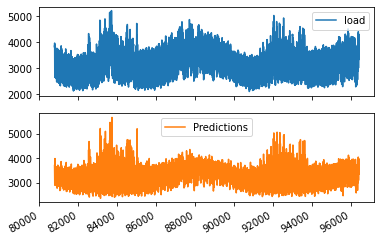

In [162]:
df_final[['load','Predictions']].plot(subplots=True)

In [161]:
df_final.head(100)

load      T  Predictions
80774  3858.0  31.33  3699.398633
80775  3807.0  31.00  3644.894946
80776  3815.0  31.00  3568.995575
80777  3880.0  31.00  3476.868983
80778  3914.0  30.00  3375.044820
...       ...    ...          ...
80869  3320.0  36.67  3648.441457
80870  3270.0  37.33  3640.368591
80871  3257.0  37.33  3608.047062
80872  3289.0  38.00  3554.653601
80873  3362.0  37.67  3484.752444

[100 rows x 3 columns]